<center><h1>2-a: Transfer learning</h1></center>
<b>Students:
<pre>
VU Anh Thu            <font color=blue>21322736</font>
LE Thi Minh Nguyet    <font color=blue>21401438</font>



In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

In [ ]:
# TODO
# Test VGG16 with or without normalization and with or without evaluation mode
def prediction(im, normalization=True, eval_mode=True, show=True):
  """
  Args:
    im: input image
    normalization: image is normalized or not
    eval_mode: evaluation mode or not
    show: image is shown or not
  """
  if show:
    plt.figure(figsize=(3, 3))
    plt.imshow(im)
    plt.axis('off')

  im = im.resize((224, 224), Image.BILINEAR)
  im = np.array(im, dtype=np.float32) / 255
  im = im.transpose((2, 0, 1))

  if normalization:
    # ImageNet mean/std
    mu = np.array([0.485, 0.456, 0.406])
    sigma = np.array([0.229, 0.224, 0.225])

    # Expand mu & sigma to match image size
    mu = mu.reshape(3, 1, 1)
    sigma = sigma.reshape(3, 1, 1)
    # compute the normalized image with mean ImageNet image
    im = (im - mu) / sigma


  # Loading ImageNet classes
  imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))
  # Loading pre-trained VGG
  vgg16 = torchvision.models.vgg16(weights='DEFAULT')

  if eval_mode:
    vgg16.eval()
  else:
    vgg16.train()

  # Forward pass on VGG
  im = np.expand_dims(im, 0)
  x = torch.Tensor(im)

  with torch.no_grad():
    y = vgg16(x)

  y = y.squeeze(0).numpy() # transformation into numpy array

  # Get prediction (i.e., ImageNet class label)
  label = imagenet_classes[np.argmax(y)]
  return label
# END TODO

In [ ]:
img = Image.open('cat.jpg')
label = prediction(img)
print (label)

### **Extension: Test VGG16 in different situations:**

*   Test on images from a diffent domain than ImageNet images
*   With and without normalizing input images
*   With and without turning on the evaluation mode



In [ ]:
# Test VGG16 on scenary images
!wget --content-disposition https://unsplash.com/photos/wjgZmYXJugc/download?force=true -O building.jpg

img = Image.open('building.jpg')
label = prediction(img)
print (label)

In [ ]:
# Test VGG16 with and without normalization
!wget --content-disposition https://unsplash.com/photos/V7SKRhXskv8/download?force=true -O goldfish.jpg
img = Image.open('goldfish.jpg')

label_normal = prediction(img, normalization=True)
print ('Prediction with normalization:', label_normal)

label_unnormal = prediction(img, normalization=False, show=False)
print ('Prediction without normalization:', label_unnormal)

In [ ]:
# Test VGG16 with and without evaluation mode
!wget --content-disposition https://unsplash.com/photos/XO4soUD-Jj4/download?force=true -O tram.jpg
img = Image.open('tram.jpg')

label_eval = prediction(img, eval_mode=True)
print ('Prediction with evaluation mode:', label_eval)

label_train = prediction(img, eval_mode=False, show=False)
print ('Prediction without evaluation mode:', label_train)

### **Extension: Visualize activation maps obtained after the first convolutional layer**

In [ ]:
# Visualize activation maps obtained after the first convolutional layer
vgg16 = models.vgg16(weights='DEFAULT')
vgg16.eval()

# ImageNet mean/std
mu = np.array([0.485, 0.456, 0.406])
sigma = np.array([0.229, 0.224, 0.225])

img = Image.open('cat.jpg')
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# Normalization
mu = mu.reshape(3, 1, 1)
sigma = sigma.reshape(3, 1, 1)
img = (img - mu) / sigma

img = np.expand_dims(img, 0)
x = torch.Tensor(img)

# Define a hook function to capture activations
def hook_fn(module, input, output):
  # Store the output (activations) of the first convolutional layer
  global activations
  activations = output.detach()

# Register the hook on the first convolutional layer
vgg16.features[0].register_forward_hook(hook_fn)

# Perform a forward pass to get activations
with torch.no_grad():
    _ = vgg16(x)

def plot_activation_maps(activation_maps):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), layout='tight')
    # Plot different activations
    for i in range(6):
        axes.flatten()[i].imshow(activation_maps[0, i].numpy(), cmap='viridis')
        axes.flatten()[i].axis('off')
        axes.flatten()[i].set_title(f"Channel {i+1}")

    plt.show()

plot_activation_maps(activations)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

In [ ]:
ls 15SceneData/test/bedroom/

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self, vgg16):
    super(VGG16relu7, self).__init__()

    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))

    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:
PRINT_INTERVAL = 50
CUDA = True

mu = np.array([0.485, 0.456, 0.406])
sigma = np.array([0.229, 0.224, 0.225])

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # TODO: duplicateChannel(), resizeImage(), toTensor(), Normalize ()
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma),
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # TODO
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma),
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
from sklearn.svm import LinearSVC

def extract_features(data, model):

    # init features matrices
    X = []
    y = []

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        # TODO
        with torch.no_grad():
          output = model(input)
          X.append(model(input))
          y.append(target)

    X = torch.cat(X).cpu().numpy()
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    y = torch.cat(y).cpu().numpy()
    # END TODO

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(weights='DEFAULT')

    print('Instanciation de VGG16relu7')

    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7(vgg16) # TODO
    model.eval()

    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = main("15SceneData", 8)

In [ ]:
# Apprentissage et évaluation des SVM à faire
print('Apprentissage des SVM')
# TODO
svm = LinearSVC(C=1.0)
svm.fit(X_train, y_train)
accuracy = svm.score(X_test, y_test)
# END TODO
print('Accuracy = %f' % accuracy)

### **Extension: Performance improvement**

In [ ]:
X_train, y_train, X_test, y_test = main("15SceneData", 8)

#### **Tune the hyperparameter $C$**

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna
def objective(trial):
    C = trial.suggest_float('C', 0.01, 2.)
    svm = LinearSVC(C=C)
    score = cross_val_score(svm, X_train, y_train, cv=4, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best parameters:', study.best_params)
print('Best score:', study.best_value)

In [ ]:
best_params = study.best_params
svm = LinearSVC(C=best_params['C'])
svm.fit(X_train, y_train)
accuracy = svm.score(X_test, y_test)
print('Accuracy = %f' % accuracy)

#### **Dimensionality reduction**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ('Shape of X_train after dimensionality reduction:', X_train_pca.shape)
print ('Shape of X_test after dimensionality reduction:', X_test_pca.shape)

In [ ]:
# Linear SVC without dimensionality reduction
import time
svm = LinearSVC(C=1.0)
start_time = time.time()
svm.fit(X_train, y_train)
accuracy = svm.score(X_test, y_test)
end_time = time.time()
print('Accuracy = %f' % accuracy)
print (f'Execution time: {end_time-start_time:.6f} seconds')

In [ ]:
# Linear SVC with dimensionality reduction
svm = LinearSVC(C=1.0)
start_time = time.time()
svm.fit(X_train_pca, y_train)
accuracy = svm.score(X_test_pca, y_test)
end_time = time.time()
print('Accuracy = %f' % accuracy)
print (f'Execution time: {end_time-start_time:.6f} seconds')

#### **Replace SVM by a fully connected layer**

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self, vgg16, dim_out):
    super(VGG16relu7, self).__init__()

    self.vgg16 = nn.Sequential(*(list(vgg16.features.children()) + [nn.Flatten()] + list(vgg16.classifier.children())[:-2]))
    self.last_layer = nn.Linear(4096, dim_out)

  def forward(self, x):
    x = self.vgg16(x)
    x = self.last_layer(x)
    return x

In [ ]:
mu = np.array([0.485, 0.456, 0.406])
sigma = np.array([0.229, 0.224, 0.225])

def get_dataset(batch_size, path):
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma),
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma),
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=CUDA, num_workers=2) # Shuffle training data to train the network
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
# Training with or without propagating the gradients to the VGG16 part
PRINT_INTERVAL = 50
CUDA = True

def one_epoch(data, model, criterion, optimizer=None, cuda=False):
  total_loss = 0
  total_correct = 0
  for i, (input, target) in enumerate(data):
    if optimizer:
        for optim in optimizer:
          optim.zero_grad()

    if cuda:
        input = input.cuda()
        target = target.cuda()

    output = model(input)
    loss = criterion(output, target)
    total_loss += loss.item()
    acc = (output.argmax(1) == target).float().mean()
    total_correct += acc.item()

    if optimizer:
      loss.backward()
      for optim in optimizer:
        optim.step()

    if i % PRINT_INTERVAL == 0:
      print(f'{"EVAL" if optimizer is None else "TRAIN"} Batch {i:03d}/{len(data):03d}\t'
            f'Loss: {loss:.6f}\t'
            f'Accuracy: {acc:.6f}'
            )

  return total_loss/len(data), total_correct/len(data)

def main(path="15SceneData", batch_size=8, lr_vgg16=None, lr_fc=1e-3, nb_epochs=20, cuda=CUDA):
    loss_train, acc_train, loss_test, acc_test = [], [], [], []
    vgg16 = models.vgg16(weights='DEFAULT')
    model = VGG16relu7(vgg16, 15)

    optim_fc = torch.optim.Adam(model.last_layer.parameters(), lr=lr_fc)
    if lr_vgg16 is not None:
        optim_vgg16 = torch.optim.Adam(model.vgg16.parameters(), lr=lr_vgg16)
    else: # Freeze the weights of VGG16 part
      for param in model.vgg16.parameters():
        param.requires_grad = False

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()

    train, test = get_dataset(batch_size, path)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(nb_epochs):
      print(f"=================\n=== EPOCH {epoch+1} =====\n=================\n")
      # Training phase
      if lr_vgg16 is not None:
        model.train()
        loss, acc = one_epoch(train, model, criterion, [optim_vgg16, optim_fc], cuda=cuda)
      else:
        model.eval()
        loss, acc = one_epoch(train, model, criterion, [optim_fc], cuda=cuda)
      loss_train.append(loss)
      acc_train.append(acc)

      # Evaluation phase
      model.eval()
      loss, acc = one_epoch(test, model, criterion, cuda=cuda)
      loss_test.append(loss)
      acc_test.append(acc)

    return loss_train, acc_train, loss_test, acc_test

In [ ]:
# Plot
import matplotlib.pyplot as plt
def plot_results(loss_train, acc_train, loss_test, acc_test):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout='tight')
  axs[0].plot(np.arange(1, len(loss_train)+1), loss_train, label='Train')
  axs[0].plot(np.arange(1, len(loss_test)+1), loss_test, label='Test')
  axs[0].legend()
  axs[0].set_title('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')

  axs[1].plot(np.arange(1, len(acc_train)+1), acc_train, label='Train')
  axs[1].plot(np.arange(1, len(acc_test)+1), acc_test, label='Test')
  axs[1].legend()
  axs[1].set_title('Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

Traing without propagating the gradients to the VGG16 part
=== EPOCH 1 =====

TRAIN Batch 000/188	Loss: 2.476691	Accuracy: 0.250000
TRAIN Batch 050/188	Loss: 0.584325	Accuracy: 0.750000
TRAIN Batch 100/188	Loss: 0.311685	Accuracy: 1.000000
TRAIN Batch 150/188	Loss: 0.475137	Accuracy: 1.000000
EVAL Batch 000/374	Loss: 0.340713	Accuracy: 0.875000
EVAL Batch 050/374	Loss: 0.475187	Accuracy: 1.000000
EVAL Batch 100/374	Loss: 0.167712	Accuracy: 1.000000
EVAL Batch 150/374	Loss: 0.302171	Accuracy: 0.875000
EVAL Batch 200/374	Loss: 0.050376	Accuracy: 1.000000
EVAL Batch 250/374	Loss: 0.338923	Accuracy: 0.875000
EVAL Batch 300/374	Loss: 0.345847	Accuracy: 1.000000
EVAL Batch 350/374	Loss: 0.243028	Accuracy: 1.000000
=== EPOCH 2 =====

TRAIN Batch 000/188	Loss: 0.237906	Accuracy: 1.000000
TRAIN Batch 050/188	Loss: 0.302434	Accuracy: 0.875000
TRAIN Batch 100/188	Loss: 0.264277	Accuracy: 1.000000
TRAIN Batch 150/188	Loss: 0.050418	Accuracy: 1.000000
EVAL Batch 000/374	Loss: 0.270703	Accuracy: 0.8

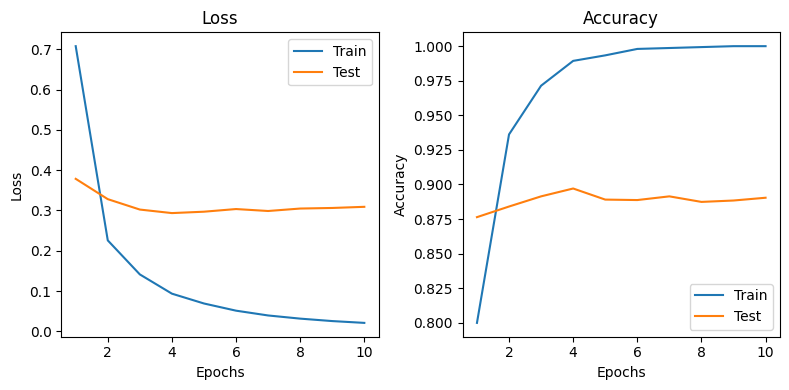

In [ ]:
print ('Traing without propagating the gradients to the VGG16 part')
loss_train, acc_train, loss_test, acc_test = main(path="15SceneData", batch_size=8, lr_vgg16=None, lr_fc=0.0005, nb_epochs=10)
plot_results(loss_train, acc_train, loss_test, acc_test)

In [ ]:
# Print test accuracies throughout the training
print (acc_test)

[0.8763368983957219, 0.884024064171123, 0.8913770053475936, 0.8970588235294118, 0.8890374331550802, 0.8887032085561497, 0.8913770053475936, 0.8873663101604278, 0.8883689839572193, 0.8903743315508021]


Traing with propagating the gradients to the VGG16 part
=== EPOCH 1 =====

TRAIN Batch 000/188	Loss: 2.896663	Accuracy: 0.000000
TRAIN Batch 050/188	Loss: 1.618205	Accuracy: 0.625000
TRAIN Batch 100/188	Loss: 0.010272	Accuracy: 1.000000
TRAIN Batch 150/188	Loss: 0.366019	Accuracy: 0.875000
EVAL Batch 000/374	Loss: 1.099390	Accuracy: 0.375000
EVAL Batch 050/374	Loss: 0.141199	Accuracy: 1.000000
EVAL Batch 100/374	Loss: 0.047773	Accuracy: 1.000000
EVAL Batch 150/374	Loss: 0.038404	Accuracy: 1.000000
EVAL Batch 200/374	Loss: 0.663424	Accuracy: 0.750000
EVAL Batch 250/374	Loss: 0.097665	Accuracy: 1.000000
EVAL Batch 300/374	Loss: 0.225143	Accuracy: 0.875000
EVAL Batch 350/374	Loss: 0.146722	Accuracy: 1.000000
=== EPOCH 2 =====

TRAIN Batch 000/188	Loss: 0.035377	Accuracy: 1.000000
TRAIN Batch 050/188	Loss: 0.266784	Accuracy: 0.875000
TRAIN Batch 100/188	Loss: 0.034449	Accuracy: 1.000000
TRAIN Batch 150/188	Loss: 0.206434	Accuracy: 0.875000
EVAL Batch 000/374	Loss: 1.213265	Accuracy: 0.6250

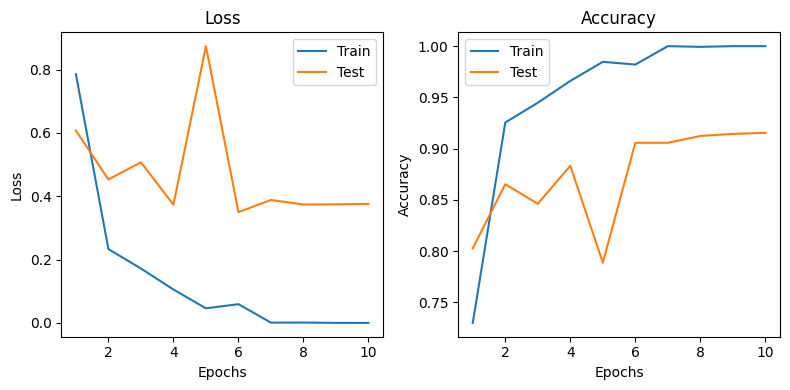

In [ ]:
print ('Traing with propagating the gradients to the VGG16 part')
loss_train, acc_train, loss_test, acc_test = main(path="15SceneData", batch_size=8, lr_vgg16=0.00005, lr_fc=0.0005, nb_epochs=10)
plot_results(loss_train, acc_train, loss_test, acc_test)

In [ ]:
# Print test accuracies throughout the training
print (acc_test)

[0.8028074866310161, 0.8653074866310161, 0.8462566844919787, 0.883355614973262, 0.7887700534759359, 0.9057486631016043, 0.9057486631016043, 0.9124331550802139, 0.9144385026737968, 0.9154411764705882]
